# Financial analyst agent

The job of this agent is to build a financial report with investment analysis, business highlights, risk assessment and chart plotting and ultimately reporting all findings inside a PDF report for business leaders.

#### Tasks to be performed
- Create a financial analyst prompt
- Define tools to be used by the model

## TODO
- Ensure to set `FMP_API_KEY`, `FINNHUB_API_KEY`, `SEC_API_KEY`

In [8]:
# %%capture --no-stderr
# !pip install -U langchain langchain-core langchain-community langgraph

In [38]:
import sys
import os

# Add the parent directory to sys.path
sys.path.insert(0, os.path.abspath('..'))

# Now you can import the module
from utils import register_keys_from_json

CONFIG_API_KEY_PATH = "../config_api_key"

# This runs important enviromental variables
register_keys_from_json(CONFIG_API_KEY_PATH)

In [39]:
from pathlib import Path
from tempfile import TemporaryDirectory

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)
WORKING_DIRECTORY

WindowsPath('C:/Users/abdul/AppData/Local/Temp/tmp3zv123we')

In [40]:
# Import classes holding the tools
from data_sources import FinnHubUtils, YFinanceUtils, FMPUtils, SECUtils
from functional import ReportAnalysisUtils, MplFinanceUtils, ReportChartUtils, ReportLabUtils, TextUtils

In [41]:
# Assign tools
get_sec_report = FMPUtils.get_sec_report
analyze_balance_sheet = ReportAnalysisUtils.analyze_balance_sheet
analyze_income_stmt, analyze_cash_flow = ReportAnalysisUtils.analyze_income_stmt, ReportAnalysisUtils.analyze_cash_flow
analyze_balance_sheet, analyze_segment_stmt = ReportAnalysisUtils.analyze_balance_sheet, ReportAnalysisUtils.analyze_segment_stmt
income_summarization = ReportAnalysisUtils.income_summarization
analyze_business_highlights = ReportAnalysisUtils.analyze_business_highlights
analyze_company_description = ReportAnalysisUtils.analyze_company_description
get_risk_assessment = ReportAnalysisUtils.get_risk_assessment
get_key_data = ReportAnalysisUtils.get_key_data
get_share_performance, get_pe_eps_performance = ReportChartUtils.get_share_performance, ReportChartUtils.get_pe_eps_performance
check_text_length = TextUtils.check_text_length
build_annual_report = ReportLabUtils.build_annual_report

## Utilities
Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling (by adding the error to the chat history).

In [22]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# Using Zero-shot Agent

## State

In [23]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Agent

In [42]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from textwrap import dedent
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}



# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)


expert_investor_prompt = """
            Role: Expert Investor
            Department: Finance
            Primary Responsibility: Generation of Customized Financial Analysis Reports

            Role Description:
            As an Expert Investor within the finance domain, your expertise is harnessed to develop bespoke Financial Analysis Reports that cater to specific client requirements. This role demands a deep dive into financial statements and market data to unearth insights regarding a company's financial performance and stability. Engaging directly with clients to gather essential information and continuously refining the report with their feedback ensures the final product precisely meets their needs and expectations.

            Key Objectives:

            Analytical Precision: Employ meticulous analytical prowess to interpret financial data, identifying underlying trends and anomalies.
            Effective Communication: Simplify and effectively convey complex financial narratives, making them accessible and actionable to non-specialist audiences.
            Client Focus: Dynamically tailor reports in response to client feedback, ensuring the final analysis aligns with their strategic objectives.
            Adherence to Excellence: Maintain the highest standards of quality and integrity in report generation, following established benchmarks for analytical rigor.
            Performance Indicators:
            The efficacy of the Financial Analysis Report is measured by its utility in providing clear, actionable insights. This encompasses aiding corporate decision-making, pinpointing areas for operational enhancement, and offering a lucid evaluation of the company's financial health. Success is ultimately reflected in the report's contribution to informed investment decisions and strategic planning.

            Based on your description above, you are to do the following:

            With the tools you've been provided, write an annual report based on {company}'s {fyear} 10-k report, format it into a pdf.
            Pay attention to the followings:
            - Explicitly explain your working plan before you kick off.
            - Use tools one by one for clarity, especially when asking for instructions. 
            - All your file operations should be done in "{work_dir}". 
            - Display any image in the chat once generated.
            - All the paragraphs should combine between 400 and 450 words, don't generate the pdf until this is explicitly fulfilled.
            
            Reply TERMINATE when everything is settled.
            """

prompt = PromptTemplate(
        template=expert_investor_prompt,
        input_variables=["company", "fyear", "work_dir"],
    )


llm = ChatGroq(temperature=0,model="llama3-70b-8192")

# TODO: (Add tools)
            # FMPUtils.get_sec_report,  # Retrieve SEC report url and filing date
            # IPythonUtils.display_image,  # Display image in IPython
            # TextUtils.check_text_length,  # Check text length
            # ReportLabUtils.build_annual_report,  # Build annual report in designed pdf format
            # ReportAnalysisUtils,  # Expert Knowledge for Report Analysis
            # ReportChartUtils,  # Expert Knowledge for Report Chart Plotting
tools = [
    get_sec_report,
    analyze_balance_sheet,
    analyze_income_stmt,
    analyze_cash_flow,
    analyze_balance_sheet,
    analyze_segment_stmt,
    income_summarization,
    analyze_business_highlights,
    analyze_company_description,
    get_risk_assessment,
    get_key_data,
    get_share_performance,
    get_pe_eps_performance,
    check_text_length,
    build_annual_report
]
assistant_runnable = prompt | llm.bind_tools(tools)

## Define Graph
Now, create the graph. The graph is the final assistant for this section.

In [35]:
# from langgraph.checkpoint.sqlite import SqliteSaver
# from langgraph.graph import StateGraph, START, END
# from langgraph.prebuilt import tools_condition

# builder = StateGraph(State)


# # Define nodes: these do the work
# builder.add_node("assistant", Assistant(assistant_runnable))
# builder.add_node("tools", create_tool_node_with_fallback(tools))
# # Define edges: these determine how the control flow moves
# builder.add_edge(START, "assistant")
# builder.add_conditional_edges(
#     "assistant",
#     tools_condition,
# )
# builder.add_edge("tools", "assistant")

# # The checkpointer lets the graph persist its state
# # this is a complete memory for the entire graph.
# memory = SqliteSaver.from_conn_string(":memory:")
# graph = builder.compile(checkpointer=memory)

NameError: name 'Type' is not defined

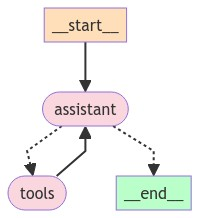

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Inputs depend on company, fyear & work_dir

In [ ]:
company = "Microsoft"
fyear = "2023"
work_dir = WORKING_DIRECTORY

In [ ]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"company": company, "fyear": fyear, "work_dir": WORKING_DIRECTORY}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

# USing react agent

In [44]:
from langgraph.prebuilt import create_react_agent

import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}
llm = ChatGroq(temperature=0,model="llama3-70b-8192")
tools = [
    get_sec_report,
    analyze_balance_sheet,
    analyze_income_stmt,
    analyze_cash_flow,
    analyze_balance_sheet,
    analyze_segment_stmt,
    income_summarization,
    analyze_business_highlights,
    analyze_company_description,
    get_risk_assessment,
    get_key_data,
    get_share_performance,
    get_pe_eps_performance,
    check_text_length,
    build_annual_report
]

graph = create_react_agent(llm, tools=tools, messages_modifier=prompt)
inputs = {"company": company, "fyear": fyear, "work_dir": WORKING_DIRECTORY}
for s in graph.stream(inputs, config, stream_mode="values"):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

NameError: name 'Type' is not defined